# **Sentiment Analisis Pengguna Aplikasi Grab**
Grab adalah salah satu aplikasi transportasi dan layanan sehari-hari terkemuka di Asia Tenggara. Aplikasi ini menyediakan berbagai layanan, termasuk transportasi, pengiriman makanan, dan pembayaran digital. Dengan jutaan pengguna, ulasan di Google Play memberikan wawasan berharga tentang pengalaman dan kepuasan pengguna. Memahami sentimen dalam ulasan pengguna dapat membantu Grab meningkatkan layanan dan pengalaman pelanggan.

**Tujuan**
1. Menganilisis sentimen pengguna

    Mengklasifikasikan ulasan pengguna menjadi sentimen positif, negatif, dan netral.
2. Mengidentifikasi Masalah Utama

    Menemukan tema atau masalah umum yang sering disebutkan dalam ulasan negatif.




# **Install Libraries**

In [2]:
!pip install sastrawi

In [3]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re # Regex
import string # Konstanta String
from nltk.tokenize import word_tokenize # Tokenize teks
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory # Stemming ke bahasa indo
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory # Menghapus stopword bahasa indo
from wordcloud import WordCloud # Vizualize word cloud

In [4]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Loading and Data Preparation**

Before cleaned

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Membaca data ulasan dari file CSV
reviews_df = pd.read_csv('/content/drive/MyDrive/Kuliah/Dicoding/Submission/grab_reviews.csv')

In [7]:
reviews_df.shape

(180000, 11)

In [8]:
print("Jumlah ulasan sebelum pembersihan:", reviews_df.shape[0])

Jumlah ulasan sebelum pembersihan: 180000


In [9]:
# Menampilkan informasi dasar dari DataFrame
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              180000 non-null  object
 1   userName              180000 non-null  object
 2   userImage             180000 non-null  object
 3   content               180000 non-null  object
 4   score                 180000 non-null  int64 
 5   thumbsUpCount         180000 non-null  int64 
 6   reviewCreatedVersion  146634 non-null  object
 7   at                    180000 non-null  object
 8   replyContent          41148 non-null   object
 9   repliedAt             41148 non-null   object
 10  appVersion            146634 non-null  object
dtypes: int64(2), object(9)
memory usage: 15.1+ MB


In [10]:
# Menampilkan dataframe teratas
reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,85a7df87-572c-4d06-9f11-e5e457eabc0a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aplikasinya bagus dan tampilan antarmukanya ju...,5,2893,5.304.1,2024-05-08 14:52:50,Hi Kak. Terima kasih sudah jadi pengguna setia...,2024-05-08 23:57:11,5.304.1
1,b19f6bff-9208-40ec-b51c-13f8f783627d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Iklan mengganggu dan memaksa, tiap kali saya k...",1,85,5.314.0,2024-07-15 21:11:52,Maaf ya atas ketidaknyamanan yang terjadi.\nKa...,2024-07-16 00:27:16,5.314.0
2,30c0b603-5c09-4864-8f48-c40b0cec85e2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Secara pelayanan aplikasi saya cukup puas, tap...",5,675,5.312.0,2024-07-15 15:07:22,NaN,NaN,5.312.0
3,e65583b9-a400-4bf0-aa7f-2f4f746721b4,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aplikasinya tolong diperbaiki. Mau ngatur titi...,4,174,5.313.0,2024-07-17 07:18:53,NaN,NaN,5.313.0
4,02d20e36-8802-4540-99b1-b71230b81744,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Guah pelanggan GRAB dari pertama ada GRAB,,, d...",5,1787,5.310.0,2024-06-17 07:47:18,Terima kasih atas kepercayaan kakak pada layan...,2024-06-17 08:13:08,5.310.0


after cleaned

In [11]:
# Menghapus baris yang memiliki missing values dan duplikat
cleaned_df = reviews_df.dropna().drop_duplicates()
print("Jumlah ulasan setelah pembersihan:", cleaned_df.shape[0])

Jumlah ulasan setelah pembersihan: 31785


# **Text Processing**

Menerapkan pembersihan teks, tokenization, dan steming untuk mempersiapkan data.

In [12]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # remove hashtags
    text = re.sub(r'RT[\s]', '', text)  # remove RT
    text = re.sub(r'http\S+', '', text)  # remove links
    text = re.sub(r'[0-9]+', '', text)  # remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation except spaces

    text = text.replace('\n', ' ')  # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove all punctuations
    text = text.strip()  # remove leading and trailing spaces
    return text

# Fungsi untuk mengubah huruf dalam teks menjadi huruf kecil
def casefoldingText(text):
    return text.lower()

# Fungsi untuk tokenisasi teks
def tokenizingText(text):
    return word_tokenize(text)

# Fungsi untuk menghapus kata-kata stop
def filteringText(tokens):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku', "di", "ga", "ya", "gaa", "loh", "kah", "woi", "woii", "woy"])
    return [word for word in tokens if word not in listStopwords]

# Fungsi untuk stemming teks
def stemmingText(text):
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    return ' '.join(stemmed_words)

# Fungsi untuk mengubah list token menjadi kalimat
def toSentence(list_words):
    return ' '.join(word for word in list_words)

In [13]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}

In [14]:
cleaned_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,85a7df87-572c-4d06-9f11-e5e457eabc0a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aplikasinya bagus dan tampilan antarmukanya ju...,5,2893,5.304.1,2024-05-08 14:52:50,Hi Kak. Terima kasih sudah jadi pengguna setia...,2024-05-08 23:57:11,5.304.1
1,b19f6bff-9208-40ec-b51c-13f8f783627d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Iklan mengganggu dan memaksa, tiap kali saya k...",1,85,5.314.0,2024-07-15 21:11:52,Maaf ya atas ketidaknyamanan yang terjadi.\nKa...,2024-07-16 00:27:16,5.314.0
4,02d20e36-8802-4540-99b1-b71230b81744,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Guah pelanggan GRAB dari pertama ada GRAB,,, d...",5,1787,5.310.0,2024-06-17 07:47:18,Terima kasih atas kepercayaan kakak pada layan...,2024-06-17 08:13:08,5.310.0
5,161f4f39-4645-4e39-9ea0-a7a7b273073b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tolonglah kalo lewat jalur ganjil-genap bikin ...,1,2,5.315.0,2024-08-01 01:03:48,Maaf ya atas ketidaknyamanan yang terjadi.\nKa...,2024-08-01 01:17:15,5.315.0
6,523ea435-93c2-45de-b5af-b129805ca5ad,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,untuk peta Google nya mohon di perbaiki kadang...,1,19,5.315.0,2024-07-23 10:15:32,Maaf ya atas ketidaknyamanan yang terjadi.\nKa...,2024-07-24 01:08:38,5.315.0
...,...,...,...,...,...,...,...,...,...,...,...
179931,1043ee7a-fb0d-47c1-b4e9-7881181a0f70,Ulfa Fafa,https://play-lh.googleusercontent.com/a/ACg8oc...,Tolong dong kenapa akun saya tiba tiba kena su...,1,0,5.210.0,2022-07-27 05:59:15,"Hai Kak, Sebelumnya maaf bgt udh bikin nggak n...",2022-07-27 08:23:50,5.210.0
179934,32aeff0b-c555-4915-9d27-b52f4f76392e,Fajar Souvenir,https://play-lh.googleusercontent.com/a-/ALV-U...,akun ya makin gila ng tau kenap ng bisa masuk ...,1,0,5.115.0,2021-03-12 12:50:15,Hai Kak. Maaf jd bikin gak nyaman ya Kak ☹️\nU...,2021-03-12 13:40:05,5.115.0
179936,fe1b8cef-86ad-4b28-84bd-639bbeaf0a80,Jihan Fauziah,https://play-lh.googleusercontent.com/a-/ALV-U...,Kenapa semakin banyak di apdet semakin gajelas.,1,0,5.110.0,2020-11-10 10:53:06,"Hai Kak Jihan, Maaf ya jadi bikin gak nyaman, ...",2020-11-10 12:26:23,5.110.0
179987,3646a715-bfa8-4cd2-9fa9-bf47f122b084,desy utami,https://play-lh.googleusercontent.com/a/ACg8oc...,ks kenapa ga bs download2 utk updatenya?,2,0,5.124.0,2021-02-25 15:43:47,"Hai Desy, Maaf ya jadi bikin gak nyaman, Kamu ...",2021-02-26 02:33:24,5.124.0


In [15]:
# Definisi Slangwords
def fix_slangwords(text):
    words = text.split()
    fixed_words = []
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [16]:
# Membersihkan Data
cleaned_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,85a7df87-572c-4d06-9f11-e5e457eabc0a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aplikasinya bagus dan tampilan antarmukanya ju...,5,2893,5.304.1,2024-05-08 14:52:50,Hi Kak. Terima kasih sudah jadi pengguna setia...,2024-05-08 23:57:11,5.304.1
1,b19f6bff-9208-40ec-b51c-13f8f783627d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Iklan mengganggu dan memaksa, tiap kali saya k...",1,85,5.314.0,2024-07-15 21:11:52,Maaf ya atas ketidaknyamanan yang terjadi.\nKa...,2024-07-16 00:27:16,5.314.0
4,02d20e36-8802-4540-99b1-b71230b81744,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Guah pelanggan GRAB dari pertama ada GRAB,,, d...",5,1787,5.310.0,2024-06-17 07:47:18,Terima kasih atas kepercayaan kakak pada layan...,2024-06-17 08:13:08,5.310.0
5,161f4f39-4645-4e39-9ea0-a7a7b273073b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tolonglah kalo lewat jalur ganjil-genap bikin ...,1,2,5.315.0,2024-08-01 01:03:48,Maaf ya atas ketidaknyamanan yang terjadi.\nKa...,2024-08-01 01:17:15,5.315.0
6,523ea435-93c2-45de-b5af-b129805ca5ad,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,untuk peta Google nya mohon di perbaiki kadang...,1,19,5.315.0,2024-07-23 10:15:32,Maaf ya atas ketidaknyamanan yang terjadi.\nKa...,2024-07-24 01:08:38,5.315.0
...,...,...,...,...,...,...,...,...,...,...,...
179931,1043ee7a-fb0d-47c1-b4e9-7881181a0f70,Ulfa Fafa,https://play-lh.googleusercontent.com/a/ACg8oc...,Tolong dong kenapa akun saya tiba tiba kena su...,1,0,5.210.0,2022-07-27 05:59:15,"Hai Kak, Sebelumnya maaf bgt udh bikin nggak n...",2022-07-27 08:23:50,5.210.0
179934,32aeff0b-c555-4915-9d27-b52f4f76392e,Fajar Souvenir,https://play-lh.googleusercontent.com/a-/ALV-U...,akun ya makin gila ng tau kenap ng bisa masuk ...,1,0,5.115.0,2021-03-12 12:50:15,Hai Kak. Maaf jd bikin gak nyaman ya Kak ☹️\nU...,2021-03-12 13:40:05,5.115.0
179936,fe1b8cef-86ad-4b28-84bd-639bbeaf0a80,Jihan Fauziah,https://play-lh.googleusercontent.com/a-/ALV-U...,Kenapa semakin banyak di apdet semakin gajelas.,1,0,5.110.0,2020-11-10 10:53:06,"Hai Kak Jihan, Maaf ya jadi bikin gak nyaman, ...",2020-11-10 12:26:23,5.110.0
179987,3646a715-bfa8-4cd2-9fa9-bf47f122b084,desy utami,https://play-lh.googleusercontent.com/a/ACg8oc...,ks kenapa ga bs download2 utk updatenya?,2,0,5.124.0,2021-02-25 15:43:47,"Hai Desy, Maaf ya jadi bikin gak nyaman, Kamu ...",2021-02-26 02:33:24,5.124.0


In [17]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
cleaned_df['text_clean'] = cleaned_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
cleaned_df['text_casefoldingText'] = cleaned_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
cleaned_df['text_slangwords'] = cleaned_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
cleaned_df['text_tokenizingText'] = cleaned_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
cleaned_df['text_stopword'] = cleaned_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
cleaned_df['text_akhir'] = cleaned_df['text_stopword'].apply(toSentence)

In [18]:
cleaned_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,85a7df87-572c-4d06-9f11-e5e457eabc0a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aplikasinya bagus dan tampilan antarmukanya ju...,5,2893,5.304.1,2024-05-08 14:52:50,Hi Kak. Terima kasih sudah jadi pengguna setia...,2024-05-08 23:57:11,5.304.1,Aplikasinya bagus dan tampilan antarmukanya ju...,aplikasinya bagus dan tampilan antarmukanya ju...,aplikasinya bagus dan tampilan antarmukanya ju...,"[aplikasinya, bagus, dan, tampilan, antarmukan...","[aplikasinya, bagus, tampilan, antarmukanya, b...",aplikasinya bagus tampilan antarmukanya bagus ...
1,b19f6bff-9208-40ec-b51c-13f8f783627d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Iklan mengganggu dan memaksa, tiap kali saya k...",1,85,5.314.0,2024-07-15 21:11:52,Maaf ya atas ketidaknyamanan yang terjadi.\nKa...,2024-07-16 00:27:16,5.314.0,Iklan mengganggu dan memaksa tiap kali saya kl...,iklan mengganggu dan memaksa tiap kali saya kl...,iklan mengganggu dan memaksa tiap kali saya kl...,"[iklan, mengganggu, dan, memaksa, tiap, kali, ...","[iklan, mengganggu, memaksa, kali, klik, tanda...",iklan mengganggu memaksa kali klik tanda silan...
4,02d20e36-8802-4540-99b1-b71230b81744,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Guah pelanggan GRAB dari pertama ada GRAB,,, d...",5,1787,5.310.0,2024-06-17 07:47:18,Terima kasih atas kepercayaan kakak pada layan...,2024-06-17 08:13:08,5.310.0,Guah pelanggan GRAB dari pertama ada GRAB dan ...,guah pelanggan grab dari pertama ada grab dan ...,guah pelanggan grab dari pertama ada grab dan ...,"[guah, pelanggan, grab, dari, pertama, ada, gr...","[guah, pelanggan, grab, grab, udh, pakai, apk,...",guah pelanggan grab grab udh pakai apk zaman a...
5,161f4f39-4645-4e39-9ea0-a7a7b273073b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tolonglah kalo lewat jalur ganjil-genap bikin ...,1,2,5.315.0,2024-08-01 01:03:48,Maaf ya atas ketidaknyamanan yang terjadi.\nKa...,2024-08-01 01:17:15,5.315.0,tolonglah kalo lewat jalur ganjilgenap bikin s...,tolonglah kalo lewat jalur ganjilgenap bikin s...,tolonglah kalau lewat jalur ganjilgenap bikin ...,"[tolonglah, kalau, lewat, jalur, ganjilgenap, ...","[tolonglah, jalur, ganjilgenap, bikin, driver,...",tolonglah jalur ganjilgenap bikin driver platn...
6,523ea435-93c2-45de-b5af-b129805ca5ad,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,untuk peta Google nya mohon di perbaiki kadang...,1,19,5.315.0,2024-07-23 10:15:32,Maaf ya atas ketidaknyamanan yang terjadi.\nKa...,2024-07-24 01:08:38,5.315.0,untuk peta Google nya mohon di perbaiki kadang...,untuk peta google nya mohon di perbaiki kadang...,untuk peta google nya mohon di perbaiki kadang...,"[untuk, peta, google, nya, mohon, di, perbaiki...","[peta, google, mohon, perbaiki, kadang, suka, ...",peta google mohon perbaiki kadang suka kasih j...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179931,1043ee7a-fb0d-47c1-b4e9-7881181a0f70,Ulfa Fafa,https://play-lh.googleusercontent.com/a/ACg8oc...,Tolong dong kenapa akun saya tiba tiba kena su...,1,0,5.210.0,2022-07-27 05:59:15,"Hai Kak, Sebelumnya maaf bgt udh bikin nggak n...",2022-07-27 08:23:50,5.210.0,Tolong dong kenapa akun saya tiba tiba kena su...,tolong dong kenapa akun saya tiba tiba kena su...,tolong dong kenapa akun saya tiba tiba kena su...,"[tolong, dong, kenapa, akun, saya, tiba, tiba,...","[tolong, akun, kena, suspend]",tolong akun kena suspend
179934,32aeff0b-c555-4915-9d27-b52f4f76392e,Fajar Souvenir,https://play-lh.googleusercontent.com/a-/ALV-U...,akun ya makin gila ng tau kenap ng bisa masuk ...,1,0,5.115.0,2021-03-12 12:50:15,Hai Kak. Maaf jd bikin gak nyaman ya Kak ☹️\nU...,2021-03-12 13:40:05,5.115.0,akun ya makin gila ng tau kenap ng bisa masuk ...,akun ya makin gila 

# **Labeling**

In [19]:
import csv
import requests
from io import StringIO

# Fungsi untuk memuat kamus dari URL
def load_lexicon(url):
    lexicon = {}
    try:
        response = requests.get(url)
        response.raise_for_status()  # Akan menimbulkan exception jika status kode bukan 200
        data = StringIO(response.text)
        reader = csv.reader(data, delimiter=',')
        for row in reader:
            if len(row) == 2:  # Memastikan baris memiliki 2 elemen (kata dan skor)
                lexicon[row[0]] = int(row[1])
    except requests.RequestException as e:
        print(f"Error fetching data from {url}: {e}")
    return lexicon

# Memuat data kamus kata-kata positif
positive_lexicon_url = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'
lexicon_positive = load_lexicon(positive_lexicon_url)

# Memuat data kamus kata-kata negatif
negative_lexicon_url = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'
lexicon_negative = load_lexicon(negative_lexicon_url)

# Menampilkan beberapa entri dari kamus positif dan negatif
print("Contoh kata-kata positif:", list(lexicon_positive.items())[:5])
print("Contoh kata-kata negatif:", list(lexicon_negative.items())[:5])


Contoh kata-kata positif: [('hai', 3), ('merekam', 2), ('ekstensif', 3), ('paripurna', 1), ('detail', 2)]
Contoh kata-kata negatif: [('putus tali gantung', -2), ('gelebah', -2), ('gobar hati', -2), ('tersentuh (perasaan)', -1), ('isak', -5)]


In [20]:
def analyze_sentiment(text, positive_lexicon, negative_lexicon):

    # Menginisialisasi skor sentimen
    sentiment_score = 0

    # Tokenisasi teks menjadi kata-kata
    words = text.split()

    # Menambahkan skor untuk kata-kata positif
    for word in words:
        if word in positive_lexicon:
            sentiment_score += positive_lexicon[word]

    # Mengurangi skor untuk kata-kata negatif
    for word in words:
        if word in negative_lexicon:
            sentiment_score += negative_lexicon[word]

    # Menentukan polaritas berdasarkan skor sentimen
    if sentiment_score > 0:
        sentiment_polarity = 'positive'
    elif sentiment_score < 0:
        sentiment_polarity = 'negative'
    else:
        sentiment_polarity = 'neutral'

    return sentiment_score, sentiment_polarity


In [21]:
def analyze_sentiment(words, positive_lexicon, negative_lexicon):

    # Menginisialisasi skor sentimen
    sentiment_score = 0

    # Menambahkan skor untuk kata-kata positif
    for word in words:
        if word in positive_lexicon:
            sentiment_score += positive_lexicon[word]

    # Mengurangi skor untuk kata-kata negatif
    for word in words:
        if word in negative_lexicon:
            sentiment_score += negative_lexicon[word]

    # Menentukan polaritas berdasarkan skor sentimen
    if sentiment_score > 0:
        sentiment_polarity = 'positive'
    elif sentiment_score < 0:
        sentiment_polarity = 'negative'
    else:
        sentiment_polarity = 'neutral'

    return sentiment_score, sentiment_polarity

def apply_sentiment_analysis(df, text_column, positive_lexicon, negative_lexicon):

    # Fungsi untuk analisis sentimen dengan kamus
    def sentiment_function(words):
        return analyze_sentiment(words, positive_lexicon, negative_lexicon)

    # Terapkan fungsi analisis sentimen pada kolom teks
    sentiment_results = df[text_column].apply(sentiment_function)

    # Pisahkan hasil menjadi skor sentimen dan polaritas
    sentiment_scores, sentiment_polarities = zip(*sentiment_results)

    # Tambahkan kolom baru ke DataFrame untuk skor sentimen dan polaritas
    df['sentiment_score'] = sentiment_scores
    df['sentiment_polarity'] = sentiment_polarities

    return df

# Terapkan analisis sentimen pada DataFrame cleaned_df
cleaned_df = apply_sentiment_analysis(cleaned_df, 'text_stopword', lexicon_positive, lexicon_negative)

# Tampilkan jumlah setiap jenis polaritas
print(cleaned_df['sentiment_polarity'].value_counts())


sentiment_polarity
negative    15413
positive    11740
neutral      4632
Name: count, dtype: int64


# **Exploratory Data Analysis (EDA)**

# Pie chart

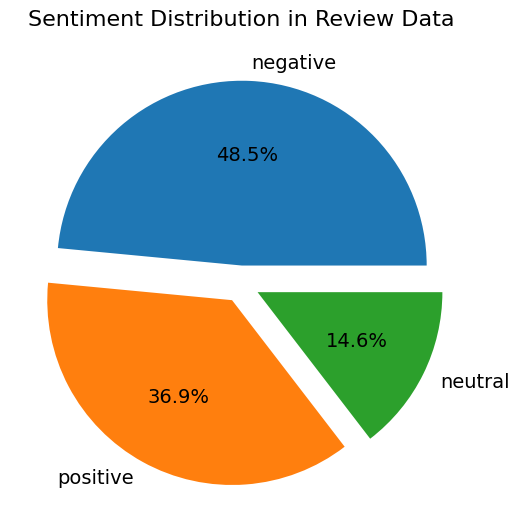

In [22]:
import matplotlib.pyplot as plt

# Buat objek gambar dan sumbu dengan ukuran 6x6 inci
fig, ax = plt.subplots(figsize=(6, 6))

# Hitung jumlah setiap jenis polaritas dari DataFrame 'cleaned_df'
sentiment_counts = cleaned_df['sentiment_polarity'].value_counts()

# Ambil ukuran untuk setiap kategori polaritas
sizes = sentiment_counts.tolist()

# Ambil label untuk setiap kategori polaritas
labels = sentiment_counts.index.tolist()

# Tentukan pemisahan potongan pie chart
# Buat 'explode' yang panjangnya sama dengan 'sizes', misalnya memberi sedikit pemisahan pada potongan pertama
explode = [0.1] * len(sizes)
explode[0] = 0.1  # Pilih potongan yang ingin dipisahkan, jika perlu

# Buat pie chart dengan data ukuran dan kategori
# autopct menampilkan persentase di setiap potongan pie chart
# textprops mengatur ukuran font teks
ax.pie(sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

# Setel judul pie chart dengan ukuran font dan jarak
ax.set_title('Sentiment Distribution in Review Data', fontsize=16, pad=20)

# Tampilkan pie chart
plt.show()


# Bar chart

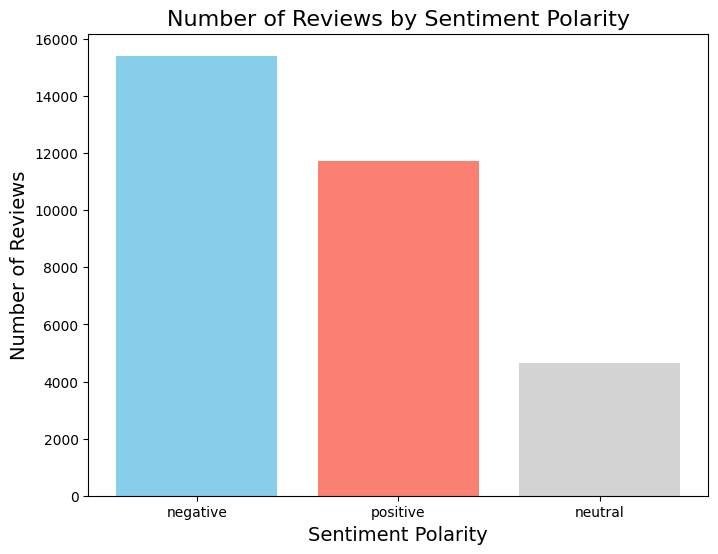

In [23]:
import matplotlib.pyplot as plt

# Hitung jumlah setiap jenis polaritas dari DataFrame 'cleaned_df'
sentiment_counts = cleaned_df['sentiment_polarity'].value_counts()

# Ambil label dan ukuran untuk setiap kategori polaritas
labels = sentiment_counts.index
sizes = sentiment_counts.values

# Buat objek gambar dan sumbu dengan ukuran 8x6 inci
fig, ax = plt.subplots(figsize=(8, 6))

# Buat bar chart dengan data ukuran dan label
ax.bar(labels, sizes, color=['skyblue', 'salmon', 'lightgrey'])

# Setel label sumbu x dan y
ax.set_xlabel('Sentiment Polarity', fontsize=14)
ax.set_ylabel('Number of Reviews', fontsize=14)

# Setel judul bar chart dengan ukuran font
ax.set_title('Number of Reviews by Sentiment Polarity', fontsize=16)

# Tampilkan bar chart
plt.show()


# Distribution

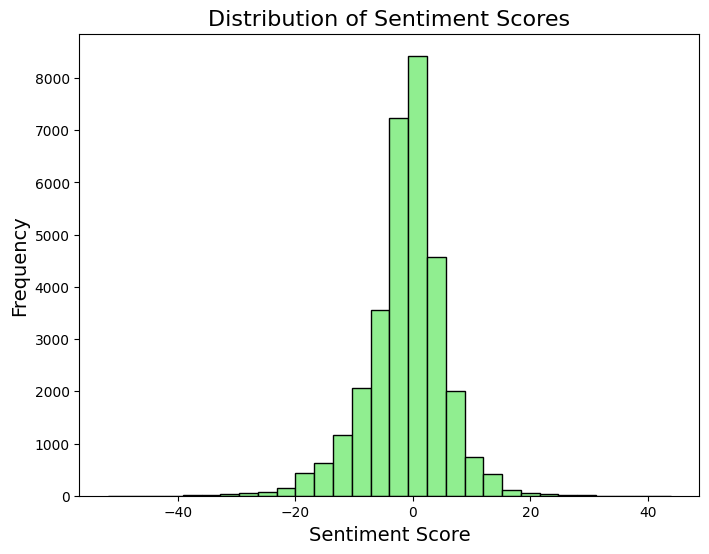

In [24]:
import matplotlib.pyplot as plt

# Buat objek gambar dan sumbu dengan ukuran 8x6 inci
fig, ax = plt.subplots(figsize=(8, 6))

# Buat histogram untuk distribusi skor sentimen
ax.hist(cleaned_df['sentiment_score'], bins=30, color='lightgreen', edgecolor='black')

# Setel label sumbu x dan y
ax.set_xlabel('Sentiment Score', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

# Setel judul histogram dengan ukuran font
ax.set_title('Distribution of Sentiment Scores', fontsize=16)

# Tampilkan histogram
plt.show()


# Word Cloud

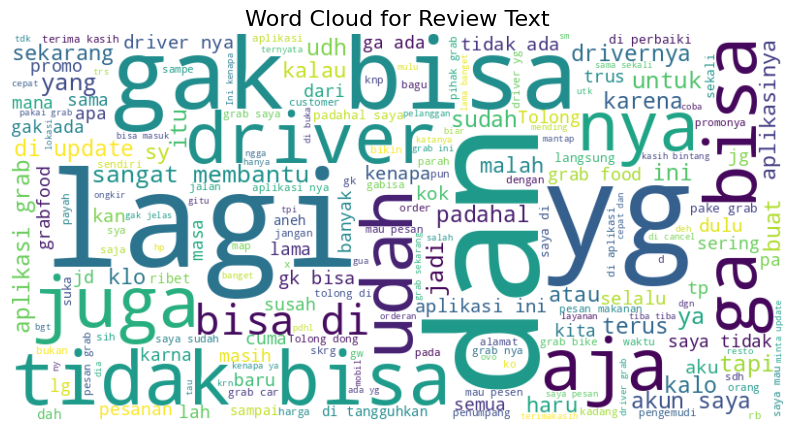

In [25]:
from wordcloud import WordCloud

# Gabungkan semua teks menjadi satu string
text = ' '.join(cleaned_df['text_clean'].astype(str))

# Buat objek WordCloud dan atur parameter visualisasi
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Buat objek gambar dan sumbu dengan ukuran 10x6 inci
fig, ax = plt.subplots(figsize=(10, 6))

# Tampilkan word cloud
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')  # Matikan sumbu

# Setel judul word cloud dengan ukuran font
ax.set_title('Word Cloud for Review Text', fontsize=16)

# Tampilkan word cloud
plt.show()


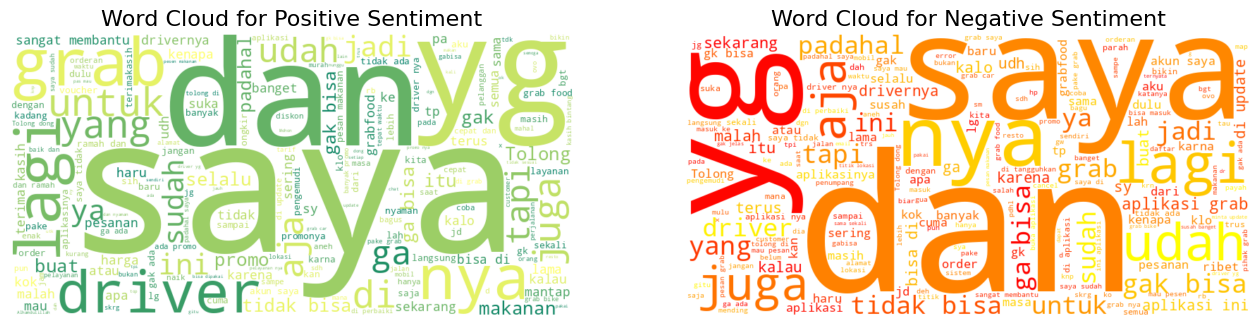

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Pisahkan teks berdasarkan polaritas sentimen
positive_text = ' '.join(cleaned_df[cleaned_df['sentiment_polarity'] == 'positive']['text_clean'].astype(str))
negative_text = ' '.join(cleaned_df[cleaned_df['sentiment_polarity'] == 'negative']['text_clean'].astype(str))

# Buat objek WordCloud untuk sentimen positif
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='summer').generate(positive_text)

# Buat objek WordCloud untuk sentimen negatif
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='autumn').generate(negative_text)

# Plot Word Cloud untuk Sentimen Positif
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(positive_wordcloud, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title('Word Cloud for Positive Sentiment', fontsize=16)

# Plot Word Cloud untuk Sentimen Negatif
ax[1].imshow(negative_wordcloud, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title('Word Cloud for Negative Sentiment', fontsize=16)

# Tampilkan kedua word cloud
plt.show()


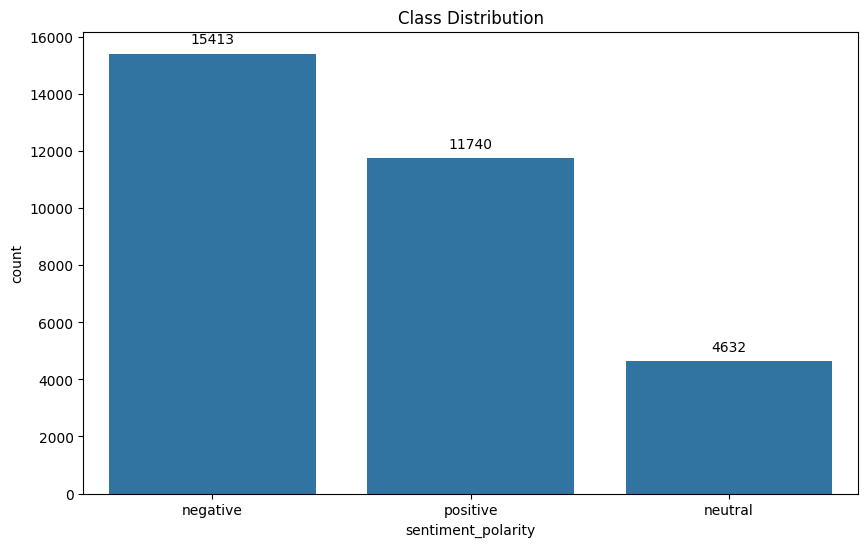

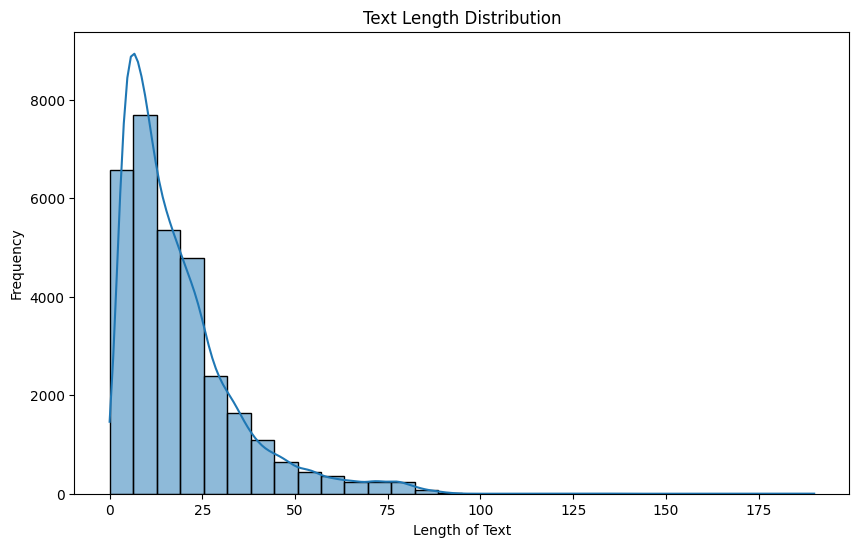

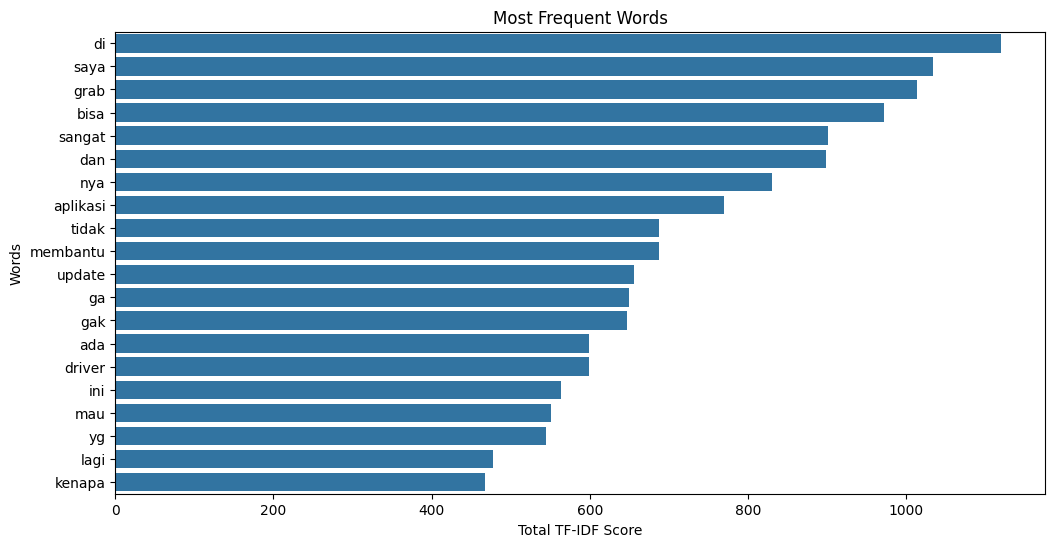

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Visualisasi Distribusi Kelas
plt.figure(figsize=(10, 6))
class_dist_plot = sns.countplot(x='sentiment_polarity', data=cleaned_df)
plt.title('Class Distribution')

# Tambahkan jumlah di atas setiap batang pada plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

plt.show()

# Visualisasi Distribusi Panjang Teks
plt.figure(figsize=(10, 6))
cleaned_df['text_length'] = cleaned_df['text_clean'].apply(lambda x: len(x.split()))
sns.histplot(cleaned_df['text_length'], bins=30, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()

# Visualisasi Kata-Kata Paling Sering Muncul
plt.figure(figsize=(12, 6))

# Menggunakan TfidfVectorizer untuk mendapatkan kata-kata paling sering
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(cleaned_df['text_clean'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_sum = tfidf_df.sum().reset_index(name='sum')
tfidf_sum = tfidf_sum.sort_values('sum', ascending=False).head(20)

sns.barplot(x='sum', y='index', data=tfidf_sum)
plt.title('Most Frequent Words')
plt.xlabel('Total TF-IDF Score')
plt.ylabel('Words')
plt.show()


# **Feature Extraction**





In [28]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

# 1. Ekstraksi fitur TF-IDF
tfidf = TfidfVectorizer(max_features=30000, min_df=17, max_df=0.8)
X_tfidf = tfidf.fit_transform(cleaned_df['text_akhir'])

# 2. Ekstraksi panjang teks
text_length = cleaned_df['text_akhir'].apply(lambda x: len(x.split())).values.reshape(-1, 1)

# 3. Gabungkan fitur TF-IDF dan panjang teks
X_combined = hstack([X_tfidf, text_length])

# Target variable
y = cleaned_df['sentiment_polarity']

In [29]:
# Konversi hasil ekstraksi fitur menjadi dataframe
tfid_features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
tfid_features_df

,abang,abangnya,ac,acara,account,adain,adakan,adil,admin,aduh,...,wilayah,wktu,wkwk,wkwkwk,worth,wrong,xl,yaaa,yah,yak
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
text_length_df = pd.DataFrame(text_length, columns=['text_length'])
text_length_df

,text_length
0,20
1,23
2,35
3,18
4,22
...,...
31780,4
31781,9
31782,2
31783,3


In [31]:
# Gabungkan DataFrame TF-IDF dan panjang teks
combined_features_df = pd.concat([tfid_features_df, text_length_df.reset_index(drop=True)], axis=1)
combined_features_df

,abang,abangnya,ac,acara,account,adain,adakan,adil,admin,aduh,...,wktu,wkwk,wkwkwk,worth,wrong,xl,yaaa,yah,yak,text_length
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
31781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
31782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
31783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [32]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)

# Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train the Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train, y_train)

# Predict on training data and test data
y_train_pred_lr = log_reg_model.predict(X_train)
y_test_pred_lr = log_reg_model.predict(X_test)

# Evaluate the model
train_accuracy_lr = accuracy_score(y_train, y_train_pred_lr)
test_accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
report = classification_report(y_test, y_test_pred_lr, target_names=y.unique())

print("Training Accuracy of Logistic Regression model:", train_accuracy_lr)
print("Test Accuracy of Logistic Regression model:", test_accuracy_lr)
print("\nClassification Report:\n", report)

Training Accuracy of Logistic Regression model: 0.9159512787091555
Test Accuracy of Logistic Regression model: 0.8942953020134228

Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.95      0.92      4547
    positive       0.87      0.69      0.77      1413
     neutral       0.90      0.91      0.91      3576

    accuracy                           0.89      9536
   macro avg       0.89      0.85      0.86      9536
weighted avg       0.89      0.89      0.89      9536



# Light GBM

In [35]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the LightGBM model
lgbm_model = lgb.LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)

# Predict on training data and test data
y_train_pred_lgbm = lgbm_model.predict(X_train)
y_test_pred_lgbm = lgbm_model.predict(X_test)

# Evaluate the model
train_accuracy_lgbm = accuracy_score(y_train, y_train_pred_lgbm)
test_accuracy_lgbm = accuracy_score(y_test, y_test_pred_lgbm)
report = classification_report(y_test, y_test_pred_lgbm, target_names=y.unique())

print("Training Accuracy of LightGBM model:", train_accuracy_lgbm)
print("Test Accuracy of LightGBM model:", test_accuracy_lgbm)
print("\nClassification Report:\n", report)


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45122
[LightGBM] [Info] Number of data points in the train set: 22249, number of used features: 1145
[LightGBM] [Info] Start training from score -0.716658
[LightGBM] [Info] Start training from score -1.933226
[LightGBM] [Info] Start training from score -1.002563
Training Accuracy of LightGBM model: 0.9007595847004359
Test Accuracy of LightGBM model: 0.8671350671140939

Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.92      0.89      4547
    positive       0.84      0.69      0.76      1413
     neutral       0.89      0.86      0.88      3576

    accuracy                           0.87      9536
   macro avg       0.86      0.83      0.84      9536
weighted avg       0.87      0.87      0.87      9536



# SVM

In [37]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Inisialisasi model SVM
svm_model = SVC(kernel='linear', random_state=42)

# Melatih model
svm_model.fit(X_train, y_train)

# Prediksi pada data pelatihan
y_train_pred_svm = svm_model.predict(X_train)

# Prediksi pada data pengujian
y_test_pred_svm = svm_model.predict(X_test)

# Evaluasi model pada data pelatihan
train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm)
print("Training Accuracy of SVM model:", train_accuracy_svm)

# Evaluasi model pada data pengujian
test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
print("Test Accuracy of SVM model:", test_accuracy_svm)

# Laporan klasifikasi
svm_report = classification_report(y_test, y_test_pred_svm, target_names=y.unique())
print("\nClassification Report:\n", svm_report)


Training Accuracy of SVM model: 0.9235021798732528
Test Accuracy of SVM model: 0.902369966442953

Classification Report:
               precision    recall  f1-score   support

    negative       0.91      0.94      0.93      4547
    positive       0.85      0.74      0.79      1413
     neutral       0.91      0.92      0.91      3576

    accuracy                           0.90      9536
   macro avg       0.89      0.87      0.88      9536
weighted avg       0.90      0.90      0.90      9536



In [40]:
from sklearn.neural_network import MLPClassifier

# Inisialisasi model MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Melatih model
mlp_model.fit(X_train, y_train)

# Prediksi pada data pelatihan
y_train_pred_mlp = mlp_model.predict(X_train)

# Prediksi pada data pengujian
y_test_pred_mlp = mlp_model.predict(X_test)

# Evaluasi model pada data pelatihan
train_accuracy_mlp = accuracy_score(y_train, y_train_pred_mlp)
print("Training Accuracy of MLP model:", train_accuracy_mlp)

# Evaluasi model pada data pengujian
test_accuracy_mlp = accuracy_score(y_test, y_test_pred_mlp)
print("Test Accuracy of MLP model:", test_accuracy_mlp)

# Laporan klasifikasi
mlp_report = classification_report(y_test, y_test_pred_mlp, target_names=y.unique())
print("\nClassification Report:\n", mlp_report)


Training Accuracy of MLP model: 0.9974380871050385
Test Accuracy of MLP model: 0.8808724832214765

Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.93      0.91      4547
    positive       0.78      0.69      0.73      1413
     neutral       0.89      0.90      0.89      3576

    accuracy                           0.88      9536
   macro avg       0.86      0.84      0.85      9536
weighted avg       0.88      0.88      0.88      9536



In [43]:
import pandas as pd

# Membuat DataFrame untuk hasil akurasi
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Light GBM', 'SVM', 'MLP'],
    'Accuracy Train': [train_accuracy_lr, train_accuracy_lgbm, train_accuracy_svm, train_accuracy_mlp],
    'Accuracy Test': [test_accuracy_lr, test_accuracy_lgbm, test_accuracy_svm, test_accuracy_mlp]
})
# Menampilkan hanya kolom "Accuracy Test"
accuracy_test_only = results_df[['Model', 'Accuracy Test']]
accuracy_test_only

,Model,Accuracy Test
0,Logistic Regression,0.894295
1,Light GBM,0.867135
2,SVM,0.902370
3,MLP,0.880872


In [48]:
# Mengurutkan DataFrame berdasarkan kolom "Accuracy Test" dari tertinggi ke terendah
accuracy_test_sorted = accuracy_test_only.sort_values(by='Accuracy Test', ascending=False)

# Menampilkan DataFrame yang telah diurutkan
accuracy_test_sorted

,Model,Accuracy Test
2,SVM,0.902370
0,Logistic Regression,0.894295
3,MLP,0.880872
1,Light GBM,0.867135


<ipython-input-47-60842324105a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(accuracy_test_sorted, x='Accuracy Test', y='Model', inner='stick', palette='Dark2')


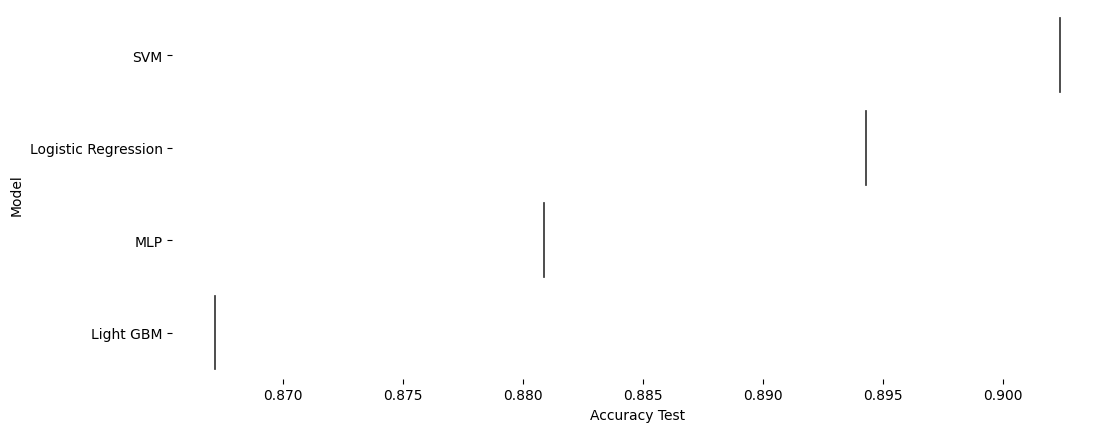

In [47]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(accuracy_test_sorted['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(accuracy_test_sorted, x='Accuracy Test', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# **Predict**

In [45]:
# Input kalimat baru dari pengguna
kalimat_baru = input("Masukkan kalimat baru: ")

# Melakukan preprocessing pada kalimat baru
kalimat_baru_cleaned = cleaningText(kalimat_baru)
kalimat_baru_casefolded = casefoldingText(kalimat_baru_cleaned)
kalimat_baru_slangfixed = fix_slangwords(kalimat_baru_casefolded)
kalimat_baru_tokenized = tokenizingText(kalimat_baru_slangfixed)
kalimat_baru_filtered = filteringText(kalimat_baru_tokenized)
kalimat_baru_final = toSentence(kalimat_baru_filtered)

# Transformasikan kalimat baru dengan TF-IDF yang sudah dilatih
X_kalimat_baru_tfidf = tfidf.transform([kalimat_baru_final])

# Ekstraksi panjang teks kalimat baru
text_length_new = len(kalimat_baru_final.split())

# Gabungkan fitur TF-IDF dan panjang teks
X_kalimat_baru_combined = hstack([X_kalimat_baru_tfidf, [[text_length_new]]])

# Memperoleh prediksi sentimen kalimat baru
prediksi_sentimen = log_reg_model.predict(X_kalimat_baru_combined)

# Menampilkan hasil prediksi
if prediksi_sentimen[0] == 'positive':
    print("Sentimen kalimat baru adalah POSITIF.")
else:
    print("Sentimen kalimat baru adalah NEGATIF.")

Masukkan kalimat baru: driver tidak tepat waktu
Sentimen kalimat baru adalah NEGATIF.
